# Kernel Quadratures


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist
import chex

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.moment import GaussHermite

import numpy as onp
from sklearn.metrics import mean_squared_error


# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.2

output_cov = 0.2
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

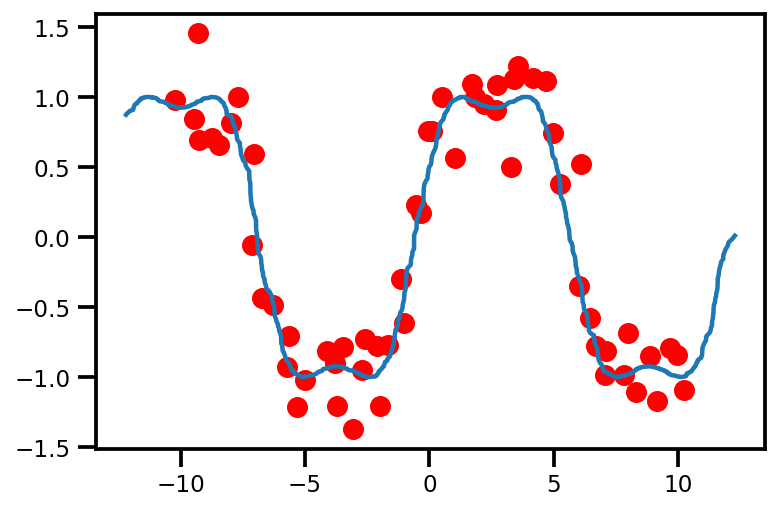

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [4]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean()

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


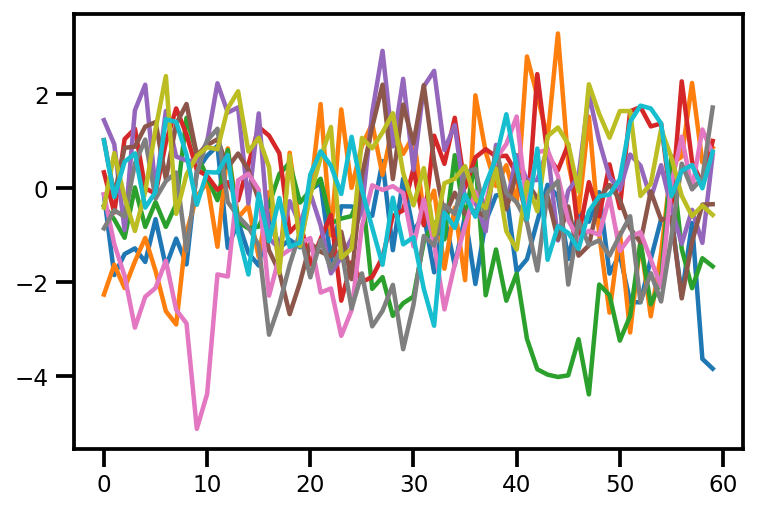

In [5]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

RationalQuadratic### Training

In [6]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=loss_f,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:03<00:00, 328.63it/s]


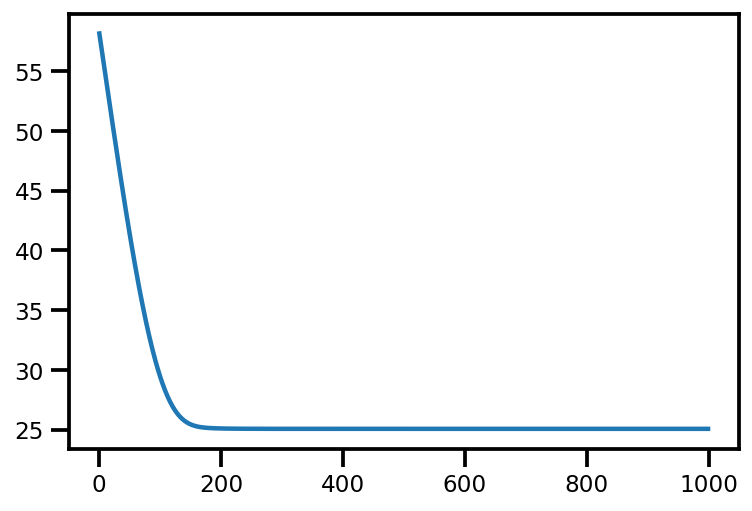

In [7]:
plt.plot(losses)

In [8]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [1.] [1.3132617] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [2.3997147] [2.4865746] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [0.69492704] [1.0997993] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.2106729] [0.2608221] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [9]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

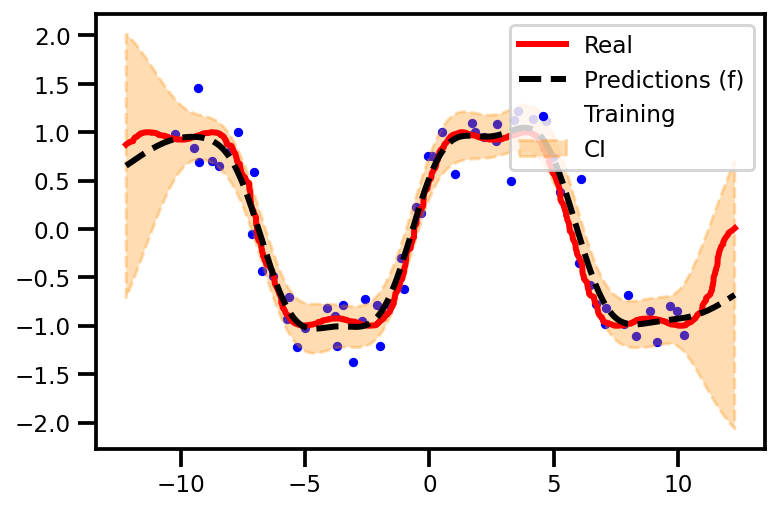

In [10]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [11]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

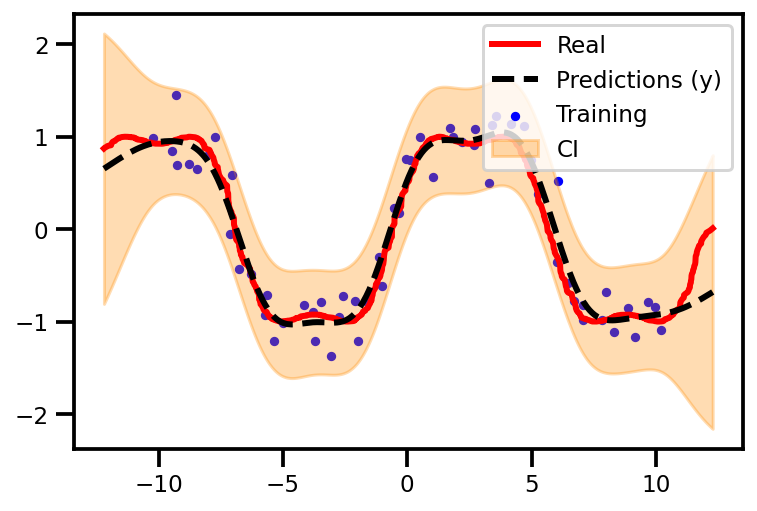

In [12]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Quadratures

In [13]:
from jaxkern.gp.uncertain.moment import moment_transform, GaussHermite
from jaxkern.gp.predictive import predictive_mean
from jaxkern.kernels.stationary import RBF, rbf_kernel

In [14]:
# initialize function
gh_quad = GaussHermite(model, degree=20)

# function
mean_f = jax.partial(predictive_mean, model)
kernel_f = model.kernel
# kernel_f = jax.partial(rbf_kernel, model.kernel.length_scale.value, model.kernel.variance.value)


# data
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))

# sigma points
sigma_points = gh_quad.sigma_points
wm = gh_quad.wm
wc = gh_quad.wc

sigma_points.shape, wm.shape, wc.shape


((1, 20), (20,), (20, 20))

## Mean Function

In [15]:
from jaxkern.kernels.expectations import MeanExpectation, mean_f_expectation

### Scalar

In [16]:
psi0 = mean_f_expectation(mean_f, sigma_points, wm, Xtest[0], Xtest_cov[0])
print(psi0)

0.6544997


### Vectorized

In [17]:
# initialize
mean_e_clf = MeanExpectation(mean_f, GaussHermite, model=model, degree=100, jitted=True)

In [18]:
mean_ef = mean_e_clf.e_px_mux(Xtest, Xtest_cov)

# check output shape
assert mean_ef.shape[0] == Xtest.shape[0]

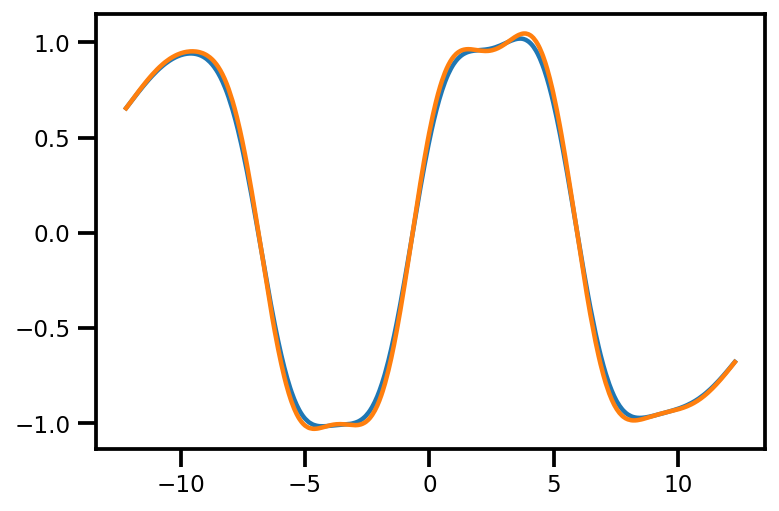

In [19]:
plt.plot(Xtest, mean_ef)
plt.plot(Xtest, mu)

In [20]:
rmse = mean_squared_error(mu.squeeze(), mean_ef.squeeze(), squared=False)
# rmse = np.sqrt(np.mean((psi0.squeeze() - mu.squeeze())**2))
assert rmse <= 0.05

## Kernel Function - X

In [21]:
from jaxkern.kernels.expectations import KernelExpectation, kernel_fx_expectation

#### Scalar

In [22]:
psi0 = kernel_fx_expectation(kernel_f, sigma_points, wm, Xtest[0], Xtest_cov[0])
print(psi0)

1.0997994


#### Vectorized

In [23]:
# initialize
kernel_expectation_clf = KernelExpectation(kernel_f, GaussHermite, model=model, degree=100, jitted=True)

In [24]:
kernel_efxx = kernel_expectation_clf.expectation_xkx(Xtest, Xtest_cov)

# check output shape
assert kernel_efxx.shape[0] == Xtest.shape[0]

# check all elements are equal
assert np.linalg.norm(kernel_efxx - kernel_efxx) == 0.0

## Kernel Function - XY

In [25]:
from jaxkern.kernels.expectations import KernelExpectation, kernel_fxy_expectation

#### Scalar

In [28]:
psi1 = kernel_fxy_expectation(kernel_f, sigma_points, wm, Xtest[0], Xtest_cov[0], X[0], )
print(psi1)

0.8322295


#### Vectorized

In [29]:
# initialize
kernel_expectation_clf = KernelExpectation(kernel_f, GaussHermite, model=model, degree=100, jitted=True)

In [30]:
psi1 = kernel_expectation_clf.expectation_xkxy(Xtest, Xtest_cov, X)

# check output shape
assert psi1.shape == (Xtest.shape[0], X.shape[0])

In [31]:
# def moment_transform_kernel_y(kernel_f, Y, X, Xcov, sigma_points, wm, wc):

#     # form sigma points from unit sigma-points
#     # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
#     x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points

#     fx_ = jax.vmap(kernel_f, in_axes=(0, None))(x_.T, Y).squeeze()

#     # output mean
#     mean_f = np.sum(fx_ * wm, axis=0)

#     return mean_f

In [32]:
# psi1 = moment_transform_kernel_y(kernel_f, X[0], Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

# print(psi1)

# # check shape
# assert psi1.shape == ()

In [33]:
# mv = jax.vmap(moment_transform_kernel_y, in_axes=(None, None, 0, 0, None, None, None), out_axes=0)
# mm = jax.vmap(mv, in_axes=(None, 0, None, None, None, None, None), out_axes=1)
# psi1 = mm(kernel_f, X, Xtest, Xtest_cov, sigma_points, wm, wc)

# # check shape
# assert psi1.shape == (Xtest.shape[0], X.shape[0])

In [34]:
mean_ef = psi1 @ model.weights

In [35]:
psi1.shape, model.weights.shape, mean_ef.shape, Xtest.shape

((1000, 60), (60, 1), (1000, 1), (1000, 1))

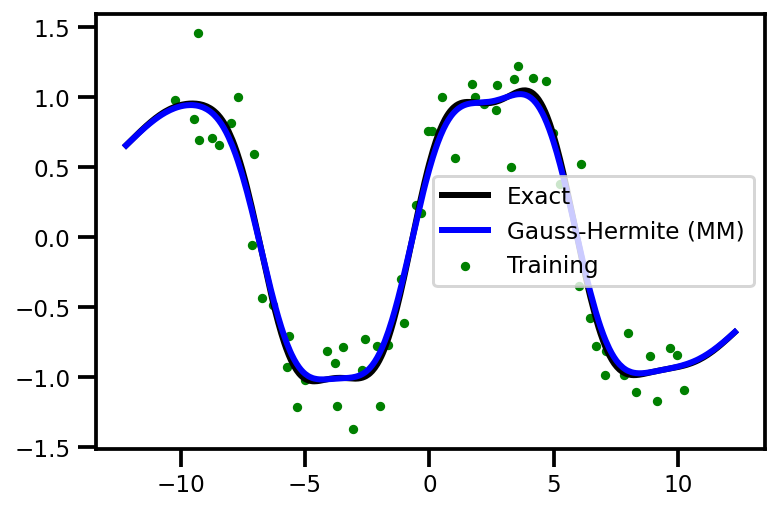

In [36]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_ef, linestyle="-", label='Gauss-Hermite (MM)', color='blue', linewidth=3)
plt.legend()

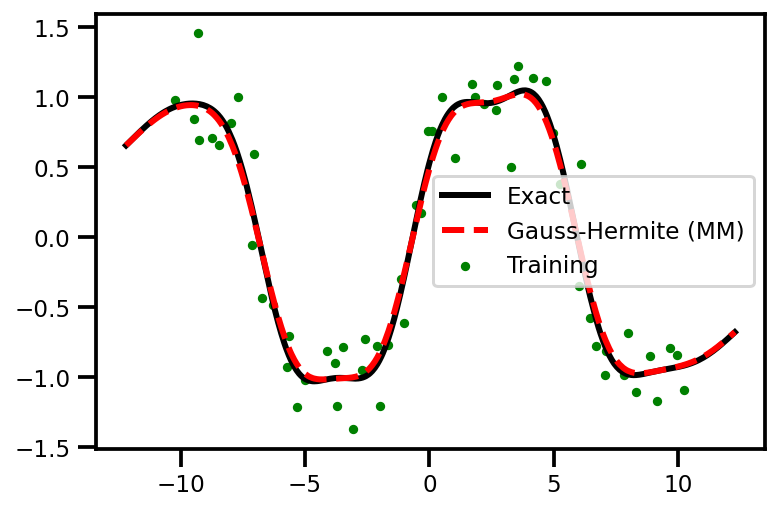

In [37]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="-", label='Exact', color='black', linewidth=3)
plt.plot(Xtest, mean_ef, linestyle="--", label='Gauss-Hermite (MM)', color='red', linewidth=3)

plt.legend()

## Kernel Function - XYZ

In [38]:
from jaxkern.kernels.expectations import KernelExpectation, kernel_fxyz_expectation

#### Scalar

In [39]:
psi2 = kernel_fxyz_expectation(kernel_f, sigma_points, wm, Xtest[0], Xtest_cov[0], X[0], X[0])
print(psi2)

0.7005352


#### Vectorized

In [60]:
# initialize
kernel_expectation_clf = KernelExpectation(kernel_f, GaussHermite, model=model, degree=100, jitted=True)


In [61]:

psi2 = kernel_expectation_clf.expectation_xkxyz(Xtest, Xtest_cov, X, X)

# check output shape
assert psi2.shape == (Xtest.shape[0], X.shape[0], X.shape[0])

In [62]:
# def moment_transform_kernel_yz(kernel_f, Z, Y, X, Xcov, sigma_points, wm, wc):

#     # form sigma points from unit sigma-points
#     # print(Xcov.shape, Xcov.shape, sigma_points.shape)
    
#     x_ = X[:, None] + np.linalg.cholesky(Xcov) @ sigma_points
    
#     def k(x, y, z):
#         return kernel_f(y, x) * kernel_f(z, x)

#     fx_ = jax.vmap(k, in_axes=(0, None, None))(x_.T, Y, Z).squeeze()

#     # output mean
#     mean_f = np.sum(fx_ * wm, axis=0)

#     return mean_f

In [63]:
# psi2 = moment_transform_kernel_yz(kernel_f, X[0], X[0], Xtest[0], Xtest_cov[0], sigma_points, wm, wc)

# print(psi2)

# # check shape
# assert psi2.shape == ()

In [64]:
# mvm = jax.vmap(moment_transform_kernel_yz, in_axes=(None, None, None, 0, 0, None, None, None), out_axes=0)
# mmv = jax.vmap(mvm, in_axes=(None, None, 0, None, None, None, None, None), out_axes=1)
# mmm = jax.vmap(mmv, in_axes=(None, 0, None, None, None, None, None, None), out_axes=2)
# psi2 = mmm(kernel_f, X, X, Xtest, Xtest_cov, sigma_points, wm, wc)

# # check shape
# assert psi2.shape == (Xtest.shape[0], X.shape[0], X.shape[0])

## Moment-Matching Transformation

In [99]:
from jaxkern.gp.uncertain.moment import MomentMatchingTransform, UnscentedTransform, GaussHermite, SphericalRadialTransform

In [105]:
mm_clf = MomentMatchingTransform(model, GaussHermite, degree=20, jitted=True)
# mm_clf = MomentMatchingTransform(model, SphericalRadialTransform, jitted=True)

In [110]:

mean_mmf, var_mmf = mm_clf.transform(Xtest, Xtest_cov)

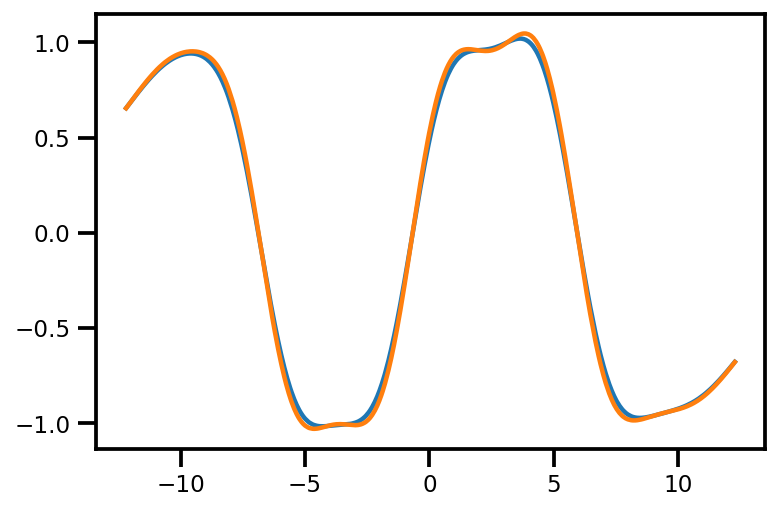

In [107]:
plt.plot(Xtest, mean_mmf)
plt.plot(Xtest, mu)

## Variance

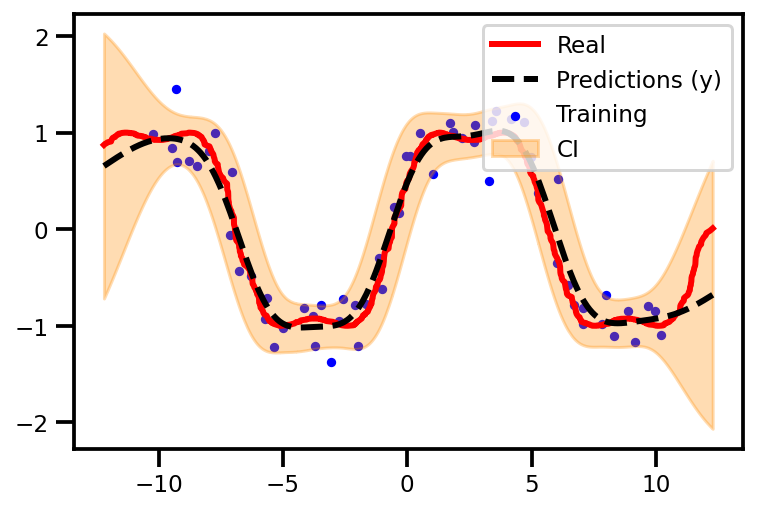

In [108]:
lb, ub = confidence_intervals(mean_mmf, var_mmf, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_mmf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

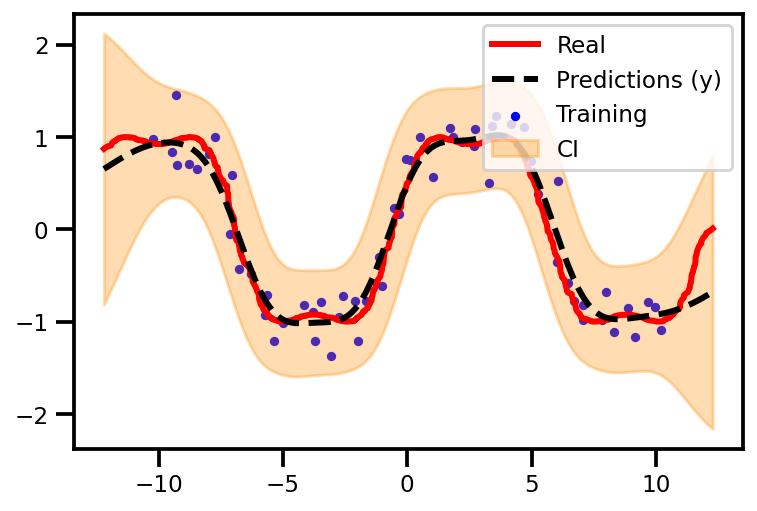

In [109]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_mmf, var_mmf  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_mmf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), 
    lb, ub, 
    label='CI', color='darkorange', alpha=0.3)

plt.legend()